# Check MLA outlier distributions

In [1]:
# !pip install matplotlib scipy

In [2]:
from safetensors import safe_open
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ls mla_ckpts/

layer00/  layer04/  layer08/  layer12/  layer16/  layer20/  layer24/
layer01/  layer05/  layer09/  layer13/  layer17/  layer21/  layer25/
layer02/  layer06/  layer10/  layer14/  layer18/  layer22/  layer26/
layer03/  layer07/  layer11/  layer15/  layer19/  layer23/


In [4]:
# ls mla_ckpts/layer00

In [5]:
use_gpu = False  # run locally
device = 0 if use_gpu else None

records_all_layer = []
for layer_id in range(27):
    records_all_iter = []
    for iter_id in range(100, 200):
        file_name = f"mla_ckpts/layer{layer_id:02}/mla_ckpt_{iter_id:03}.safetensors"
        tensors = {}
        with safe_open(file_name, framework="pt", device=device) as f:
            for k in f.keys():
                tensors[k] = f.get_tensor(k)
        records_all_iter.append(tensors)
    records_all_layer.append(records_all_iter)

## records_all_layer  # too long, do not pring

In [6]:
tensors = records_all_layer[0][2]
for name, tensor in tensors.items():
    print(name, tensor.shape, tensor.dtype, tensor.device, sep=" | ")

kv_cache_used | torch.Size([8, 123, 512]) | torch.bfloat16 | cpu
output_x | torch.Size([8, 1, 16, 512]) | torch.bfloat16 | cpu
pe_cache_used | torch.Size([8, 123, 64]) | torch.bfloat16 | cpu
q_nope | torch.Size([8, 1, 16, 512]) | torch.bfloat16 | cpu
q_pe | torch.Size([8, 1, 16, 64]) | torch.bfloat16 | cpu
scores | torch.Size([8, 1, 16, 123]) | torch.bfloat16 | cpu
softmax_scale | torch.Size([]) | torch.bfloat16 | cpu


In [7]:
def to_numpy(x):
    # numpy has no BFloat16 dtype
    return x.cpu().to(torch.float32).numpy()

def extract_q(all_records, key="q_nope"):
    all_output = []
    for records in all_records:
        temp_output = []
        for record in records:
            data = to_numpy(record[key])
            temp_output.append(data)
            # print(data.shape)
            
        temp_output = np.concatenate(temp_output, axis=1)
        all_output.append(temp_output)
    return np.stack(all_output)

def extract_kv(all_records, key="kv_cache_used"):
    all_output = []
    for records in all_records:
        record = records[-1]  # last iter contains full cache
        data = to_numpy(record[key])
        all_output.append(data)
    return np.stack(all_output)

In [8]:
%%time
q_nope_all = extract_q(records_all_layer)
q_nope_all.shape  # [layer, batch, iter(seq), head, hidden]

CPU times: user 31.3 s, sys: 470 ms, total: 31.8 s
Wall time: 1.09 s


(27, 8, 100, 16, 512)

In [9]:
kv_cache_all = extract_kv(records_all_layer)
kv_cache_all.shape # [layer, batch, seq(last_iter), head, hidden]

(27, 8, 220, 512)

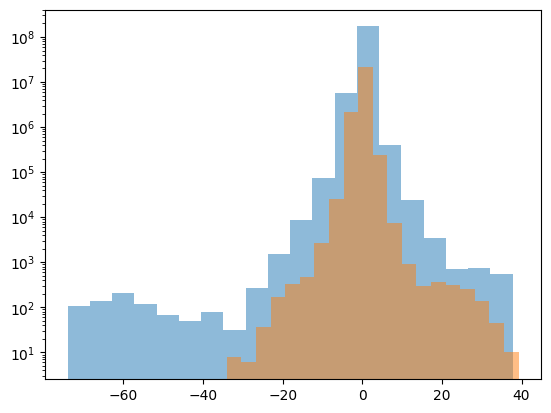

In [10]:
plt.hist(q_nope_all.flatten(), log=True, bins=20, alpha=0.5);
plt.hist(kv_cache_all.flatten(), log=True, bins=20, alpha=0.5);

## Hadamard

In [11]:
from scipy.linalg import hadamard

K = q_nope_all.shape[-1]
H = hadamard(K, dtype=np.float32) / np.sqrt(K)
H.shape

(512, 512)

In [12]:
%%time
q_nope_all_rotate = q_nope_all @ H
kv_cache_all_rotate = kv_cache_all @ H

CPU times: user 2min 14s, sys: 1.74 s, total: 2min 15s
Wall time: 4.45 s


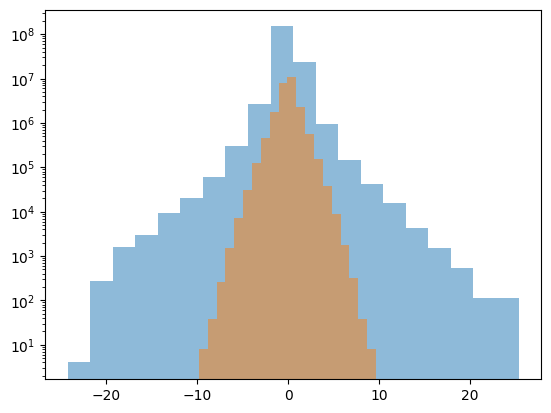

In [13]:
plt.hist(q_nope_all_rotate.flatten(), log=True, bins=20, alpha=0.5);
plt.hist(kv_cache_all_rotate.flatten(), log=True, bins=20, alpha=0.5);

## FP16 vs INT8 GEMM

In [14]:
# TBD